# Color image filtering 

Goal: to get only lane lines on the image

In [1]:
from typing import List
import cv2
import numpy as np

import matplotlib.pyplot as plt

## Utils to process image

In [2]:
def abs_sobel_thresh(img: np.ndarray, orient='x', thresh_min=25, thresh_max=255) -> np.ndarray:
    """
    Thresholds image using Sobel filter
    :param img: image to filter
    :param orient: filter by 'x' axis of by 'y' axis
    :param thresh_min: min threshold for gradient
    :param thresh_max:  max threshold for gradient
    :return: preprocessed image
    """
    # Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


def color_threshold(image: np.ndarray, sthresh=(0, 255), vthresh=(0, 255)) -> np.ndarray:
    """
    Thresholds image using HSV and HLS color models
    :param image: image to filter
    :param sthresh: saturation threshold
    :param vthresh: value threshold
    :return: preprocessed image
    """
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > sthresh[0]) & (s_channel <= sthresh[1])] = 1

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:, :, 2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel > vthresh[0]) & (v_channel <= vthresh[1])] = 1

    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary) == 1] = 1

    # Return the combined s_channel & v_channel binary image
    return output

## Cut video

In [3]:
def cut_video(video_path: str) -> List[np.ndarray]:
    cap = cv2.VideoCapture(video_path)
    success, image = cap.read()

    images = []

    if cap.isOpened():
        while success:
            images.append(image)
            success, image = cap.read()
        return images
    else:
        print('Video opening error!')
        return -1

In [4]:
CHALLENGE_VIDEO = 'videos/challenge_2.mp4'

images = cut_video(CHALLENGE_VIDEO)

In [5]:
TEST_IMG_1 = 'test images/test_1.jpg'
TEST_IMG_2 = 'test images/test_2.jpg'
cv2.imwrite(TEST_IMG_1, images[50])
cv2.imwrite(TEST_IMG_2, images[150])

True

## Plot test image

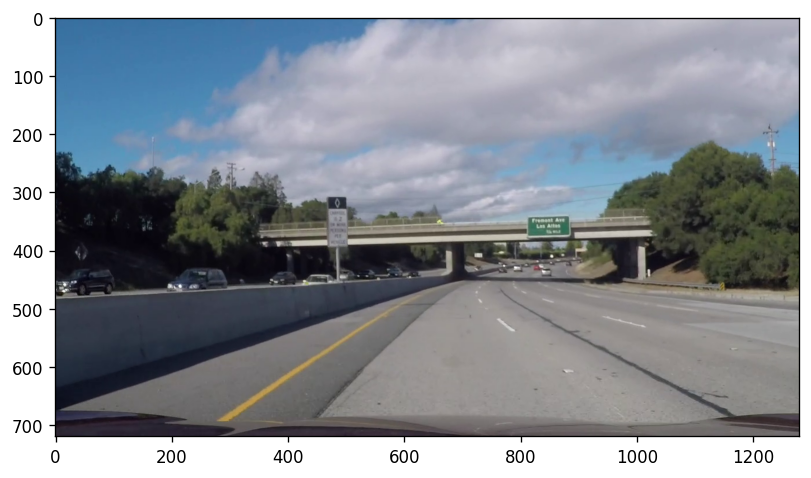

In [41]:
test_img = images[50]
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(test_img)

## Get orange mask

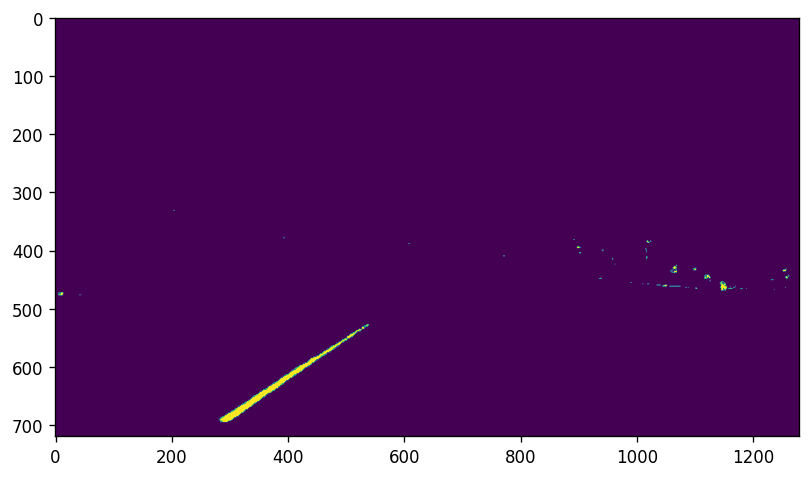

In [46]:
orange_line = color_threshold(test_img, sthresh=(100, 255), vthresh=(20, 255))

hsv = cv2.cvtColor(test_img, cv2.COLOR_RGB2HSV)
orange_line = cv2.inRange(hsv,(15, 100, 0), (30, 255, 200)) > 0
#cv2.imshow("orange", mask);cv2.waitKey();cv2.destroyAllWindows()

plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(orange_line)

## Get white mask

[False  True]


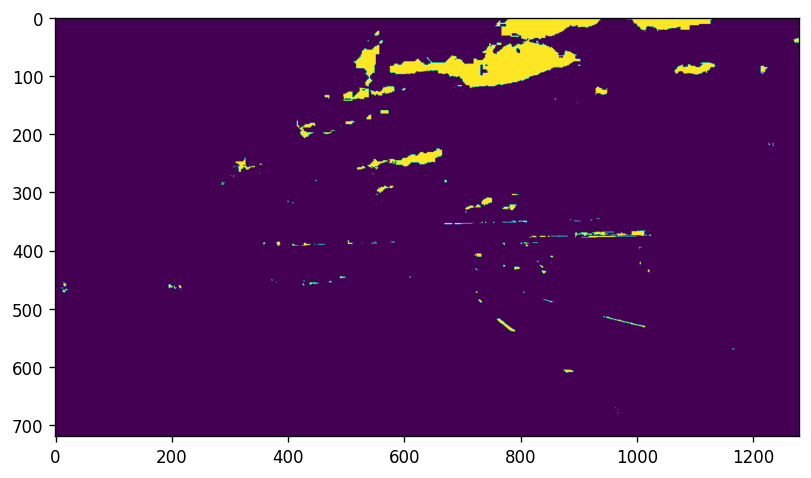

In [45]:
white_line = color_threshold(test_img, sthresh=(100, 255), vthresh=(20, 255))

hsv = cv2.cvtColor(test_img, cv2.COLOR_RGB2HSV)
white_line = cv2.inRange(hsv,(0, 0, 180), (180, 15, 255)) > 0
#cv2.imshow("orange", mask);cv2.waitKey();cv2.destroyAllWindows()

print(np.unique(white_line))
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(white_line)

## Filter image

[False  True]


c:\users\vadim\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


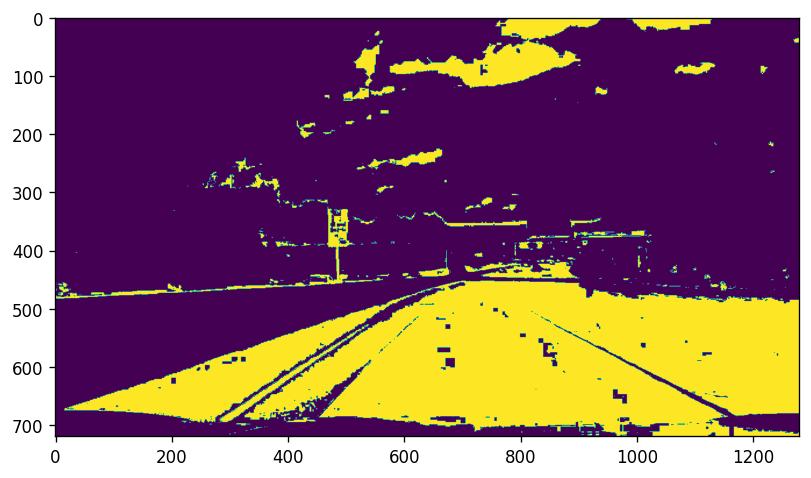

In [44]:
# Apply Sobel operator in X-direction to experiment with gradient thresholds
grad_x = abs_sobel_thresh(test_img, orient='x', thresh_min=20, thresh_max=100)

# Apply Sobel operator in Y-direction to experiment with gradient thresholds
grad_y = abs_sobel_thresh(test_img, orient='y', thresh_min=20, thresh_max=100)

# Experiment with HLS & HSV color spaces along with thresholds
c_binary = color_threshold(test_img, sthresh=(100, 255), vthresh=(100, 255))

preprocessImage = np.zeros_like(test_img[:, :, 0])
preprocessImage[((orange_line == 1) | (white_line == 1))] = 255

print(np.unique(white_line))
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(preprocessImage)